# mlbotの初心者向けチュートリアル(Bybit版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBybit向けに記載したものです。


## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [57]:
import math

import ccxt
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

## データを用意


In [88]:
import ccxt
import datetime
import pandas as pd
from datetime import datetime, timezone, timedelta

exchange = ccxt.bybit()

start_date = datetime(2022, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2024, 3, 1, tzinfo=timezone.utc)

start_timestamp = int(start_date.timestamp()) * 1000
end_timestamp = int(end_date.timestamp()) * 1000

df_list = []

while True:

    kline = exchange.publicGetV5MarketKline({
        'symbol': 'BTCUSDT',
        'end': end_timestamp,
        'interval': '15',
        'limit': 200
    })['result']['list']

    df = pd.DataFrame(kline, columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume', 'turnover'])
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='ms', utc=True)
    df_list.append(df)

    #print(kline)

    #最後の時間を取得
    last_time = int(kline[-1][0])
    end_timestamp = last_time - 1

    if last_time < start_timestamp:
        break
    if len(kline) < 10:
        break

df = pd.concat(df_list, axis=0)
# slice data
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
df = df.set_index('timestamp')
df = df.sort_values('timestamp', ascending=True)
columns_to_convert = ['op', 'hi', 'lo', 'cl', 'volume']
df[columns_to_convert] = df[columns_to_convert].astype(float)
display(df)
df.to_pickle('df_ohlcv_bybit.pkl')

,op,hi,lo,cl,volume,turnover
timestamp,,,,,,
2022-01-01 00:00:00+00:00,46200.5,46525.5,46200.5,46327.0,580.667,26918279.999
2022-01-01 00:15:00+00:00,46327.0,46403.0,46256.5,46373.5,246.644,11430771.842
2022-01-01 00:30:00+00:00,46373.5,46692.5,46373.5,46637.5,641.962,29886669.5865
2022-01-01 00:45:00+00:00,46637.5,46736.0,46600.0,46657.0,382.823,17873094.852
2022-01-01 01:00:00+00:00,46657.0,46776.0,46580.0,46766.0,304.265,14202064.8035
...,...,...,...,...,...,...
2024-02-29 23:00:00+00:00,61270.3,61414.5,61216.0,61280.3,1392.637,85390760.8568
2024-02-29 23:15:00+00:00,61280.3,61566.0,61268.0,61500.0,1218.082,74839508.9184
2024-02-29 23:30:00+00:00,61500.0,61598.1,61360.2,61421.0,1212.858,74575574.9524


## maker手数料カラムを追加


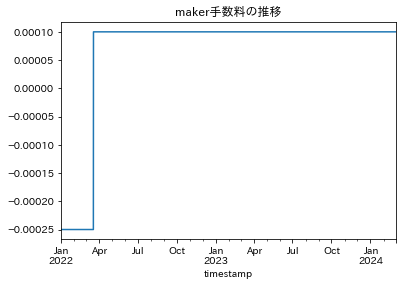

,op,hi,lo,cl,volume,turnover,fee
timestamp,,,,,,,
2022-01-01 00:00:00+00:00,46200.5,46525.5,46200.5,46327.0,580.667,26918279.999,-0.00025
2022-01-01 00:15:00+00:00,46327.0,46403.0,46256.5,46373.5,246.644,11430771.842,-0.00025
2022-01-01 00:30:00+00:00,46373.5,46692.5,46373.5,46637.5,641.962,29886669.5865,-0.00025
2022-01-01 00:45:00+00:00,46637.5,46736.0,46600.0,46657.0,382.823,17873094.852,-0.00025
2022-01-01 01:00:00+00:00,46657.0,46776.0,46580.0,46766.0,304.265,14202064.8035,-0.00025
...,...,...,...,...,...,...,...
2024-02-29 23:00:00+00:00,61270.3,61414.5,61216.0,61280.3,1392.637,85390760.8568,0.00010
2024-02-29 23:15:00+00:00,61280.3,61566.0,61268.0,61500.0,1218.082,74839508.9184,0.00010
2024-02-29 23:30:00+00:00,61500.0,61598.1,61360.2,61421.0,1212.858,74575574.9524,0.00010


In [89]:
maker_fee_history = [
    {
        # https://blog.bybit.com/post/new-fee-rates-on-bybit-blt28c785842d338877/
        # maker手数料 0.01%
        'changed_at': '2022/03/18 05:0:00Z',
        'maker_fee': 0.0001
    },
]

df = pd.read_pickle('df_ohlcv_bybit.pkl')

# 初期の手数料
# maker手数料 -0.025%
df['fee'] =-0.00025

for config in maker_fee_history:
    df.loc[pd.to_datetime(config['changed_at']) <= df.index, 'fee'] = config['maker_fee']


df['fee'].plot()
plt.title('maker手数料の推移')
plt.show()
    
display(df)
df.to_pickle('df_ohlcv_bybit_with_fee.pkl')

## 特徴量エンジニアリング


In [90]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

df = pd.read_pickle('df_ohlcv_bybit_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
display(df)
df.to_pickle('df_bybit_features.pkl')

,op,hi,lo,cl,volume,turnover,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,46200.5,46525.5,46200.5,46327.0,580.667,26918279.999,-0.00025,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:15:00+00:00,46327.0,46403.0,46256.5,46373.5,246.644,11430771.842,-0.00025,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:30:00+00:00,46373.5,46692.5,46373.5,46637.5,641.962,29886669.5865,-0.00025,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:45:00+00:00,46637.5,46736.0,46600.0,46657.0,382.823,17873094.852,-0.00025,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 01:00:00+00:00,46657.0,46776.0,46580.0,46766.0,304.265,14202064.8035,-0.00025,216.683051,-125.80,-468.283051,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,171.241525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:00:00+00:00,61270.3,61414.5,61216.0,61280.3,1392.637,85390760.8568,0.00010,282.185541,-177.11,-636.405541,...,-0.870599,-0.963498,0,3.298369,0.924471,-342.951429,-89.273069,681.637143,-78.814505,229.647770
2024-02-29 23:15:00+00:00,61280.3,61566.0,61268.0,61500.0,1218.082,74839508.9184,0.00010,270.821260,-251.26,-773.341260,...,-0.999995,-0.709400,0,1.809788,0.905972,-515.780000,-89.176220,388.337143,-69.547473,261.040630
2024-02-29 23:30:00+00:00,61500.0,61598.1,61360.2,61421.0,1212.858,74575574.9524,0.00010,301.119360,-239.21,-779.539360,...,-0.905581,-0.340406,0,1.715240,0.878659,-356.777143,-88.868159,301.220000,-50.615165,270.164680


## 学習に使う特徴量の定義

以下のコードでは学習に使う特徴量カラムを指定しています。
特徴量は私が適当に選んだものです。
コメントアウトなどでいろいろな組み合わせを試すと良いと思います。
特徴量選択もおすすめです。
Kaggleで勝つデータ分析の技術などで勉強すると良いと思います。

In [91]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


## 目的変数の計算


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


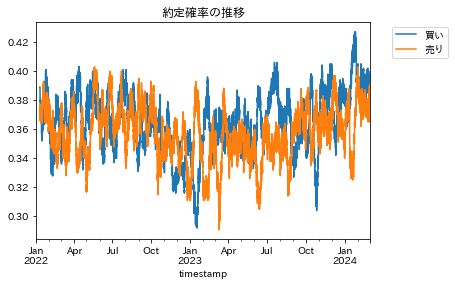

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


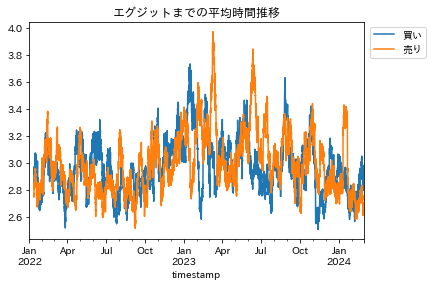

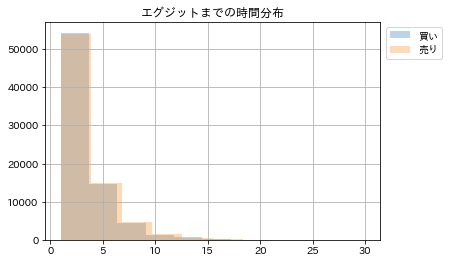

毎時刻、この執行方法でトレードした場合の累積リターン


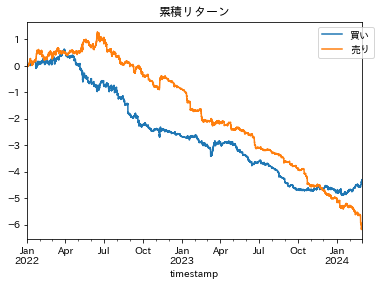

In [92]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bybit_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.5

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bybit_y.pkl')

## モデルの学習とOOS予測値計算


毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


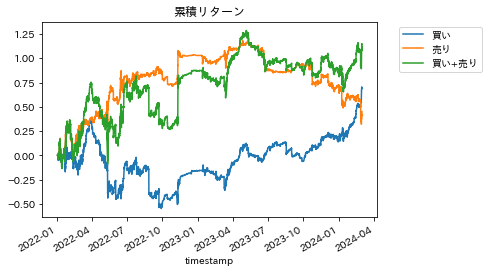

In [116]:
df = pd.read_pickle('df_bybit_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
#model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy_bybit.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell_bybit.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bybit_fit.pkl')

## バックテストと検定



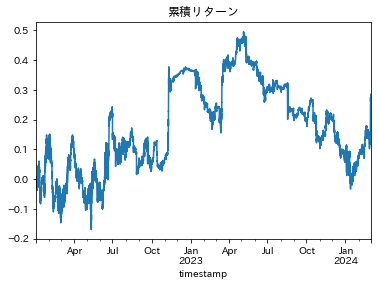

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


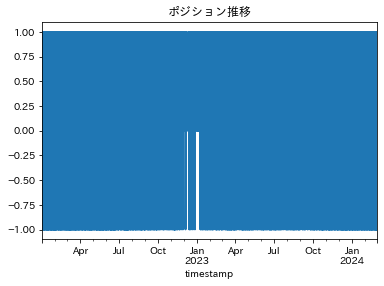

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


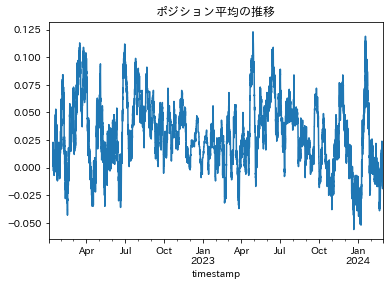

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


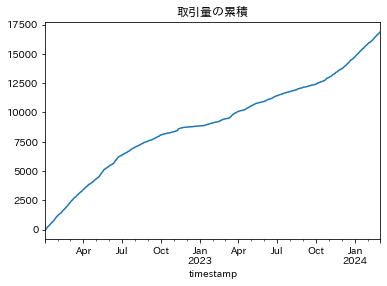

t検定
t値 0.4666130130681588
p値 0.6407781169870898
p平均法 n = 5
p平均 0.7124786654617522
エラー率 4.781102970693538


In [113]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_bybit_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用



In [114]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定

Bybitが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [115]:
#BybitのOHLCV情報を取得
def get_bybit_ohlcv(from_time,interval,limit):
    kline = exchange.publicGetV5MarketKline({
        'symbol': 'BTCUSDT',
        'start': from_time,
        'interval': interval,
        'limit': limit
    })['result']['list']
    df = pd.DataFrame(kline, columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume', 'turnover'])
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='ms', utc=True)
    df = df.set_index('timestamp')
    df = df.sort_values('timestamp', ascending=True)
    columns_to_convert = ['op', 'hi', 'lo', 'cl', 'volume']
    df[columns_to_convert] = df[columns_to_convert].astype(float)
    return df
    
#買いポジションの判定
def calc_position_buy(x):
    buy = x["predict_y_buy"]
    if buy > 0:
        return "buy"
    else:
        return "none"
    
#売りポジションの判定
def calc_position_sell(x):
    buy = x["predict_y_sell"]
    if buy > 0:
        return "sell"
    else:
        return "none"

#OHLCVの取得
time_now = datetime.now()
interval = 15
from_time = int((time_now + timedelta(minutes= -200 * interval)).timestamp()) * 1000
limit = 200
df = get_bybit_ohlcv(from_time,interval,limit)

#特徴量の計算
df_features = calc_features(df)

#モデルの読み込み
model_y_buy = joblib.load('./model_y_buy_bybit.xz')
model_y_sell = joblib.load('./model_y_sell_bybit.xz')

#推論
df_features["predict_y_buy"] = model_y_buy.predict(df_features[features].fillna(0))
df_features["predict_y_sell"] = model_y_sell.predict(df_features[features].fillna(0))

#ポジションの判定
df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

display(df_features)

position_buy = df_features["position_buy"].iloc[-1]
position_sell = df_features["position_sell"].iloc[-1]

if position_buy == "buy" and position_sell == "none":
    print("Buy Bitcoin")
elif position_sell == "sell" and position_buy == "none":
    print("Sell Bitcoin")
else:
    print("N/A")

,op,hi,lo,cl,volume,turnover,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,predict_y_buy,predict_y_sell,position_buy,position_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-19 15:00:00+00:00,62931.2,63101.1,62641.0,62835.3,2438.031,153344415.3605,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000841,-0.000347,none,none
2024-03-19 15:15:00+00:00,62835.3,63213.8,62626.1,63027.5,2262.524,142439049.2636,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000841,-0.000347,none,none
2024-03-19 15:30:00+00:00,63027.5,64070.5,63011.5,63987.4,4306.798,274209343.9397,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000841,-0.000347,none,none
2024-03-19 15:45:00+00:00,63987.4,64213.0,63769.6,64090.0,2953.805,189069629.2844,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.000841,-0.000347,none,none
2024-03-19 16:00:00+00:00,64090.0,64691.0,64004.9,64351.0,5208.273,335261743.2929,526.757874,-689.71,-1906.177874,NaN,...,NaN,NaN,NaN,NaN,NaN,608.233937,-0.005654,-0.006009,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-21 15:45:00+00:00,66466.6,66593.0,66250.3,66588.7,1303.220,86609101.5755,523.056748,96.99,-329.076748,448.634189,...,0.898261,-150.945714,-89.284915,890.617143,-80.120220,213.033374,-0.000509,0.000519,none,sell
2024-03-21 16:00:00+00:00,66588.7,66588.8,66203.0,66411.5,1607.846,106698188.6925,230.576895,26.48,-177.616895,412.058274,...,0.907814,-80.674286,-89.348674,1062.860000,-87.964176,102.048447,0.000266,0.000768,buy,sell
2024-03-21 16:15:00+00:00,66411.5,66798.8,66303.4,66706.0,1543.561,102829277.2886,229.385643,-58.96,-347.305643,237.438994,...,0.906774,-371.911429,-89.294094,683.197143,-81.162198,144.172821,-0.001397,0.002038,none,sell


N/A
